In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

# Read in CESM output

In [2]:
# Offline simulations where low=5th percentile Medlyn slope, high=95th percentile Medlyn slope
data_path = '/glade/scratch/czarakas/archive/landOnly_GSWP3_LOWmedslope_1xCO2/lnd/hist/'
low_1xCO2 = xr.open_mfdataset(data_path+'*h1*.nc', combine='by_coords')

data_path = '/glade/scratch/czarakas/archive/landOnly_GSWP3_DEFmedslope_1xCO2/lnd/hist/'
def_1xCO2 = xr.open_mfdataset(data_path+'*h1*.nc', combine='by_coords')

data_path = '/glade/scratch/czarakas/archive/landOnly_GSWP3_HIGHmedslope_1xCO2/lnd/hist/'
high_1xCO2 = xr.open_mfdataset(data_path+'*h1*.nc', combine='by_coords')

In [3]:
# Offline simulations with alternate low values for shrub Medlyn slope (10th percentile and 25th percentile) 
data_path = '/glade/scratch/czarakas/archive/landOnly_GSWP3_LOWv2medslope_1xCO2/lnd/hist/'
low2_1xCO2 = xr.open_mfdataset(data_path+'*h1*.nc', combine='by_coords')

data_path = '/glade/scratch/czarakas/archive/landOnly_GSWP3_LOWv3medslope_1xCO2/lnd/hist/'
low3_1xCO2 = xr.open_mfdataset(data_path+'*h1*.nc', combine='by_coords')

In [4]:
pftnames=['', #0
          'NET, Temp', #1
          'NET, Boreal', #2
          'NDT, Boreal', #3
          'BET, Trop', #4
          'BET, Temp', #5
          'BDT, Trop', #6
          'BDT, Temp', #7
          'BDT, Boreal', #8
          'BES, Temp', #9
          'BDS, Temp', #10
          'BDS, Boreal', #11
          'C3 arctic grass', #12
          'C3 non-arctic grass', #13
          'C4 grass', #14
          'Crop',
          'Crop']
pftnums = np.unique(high_1xCO2.pfts1d_itype_veg)

# Distribution of LAI for each PFT
quick first look: not currently weighting time average to account for different days per month

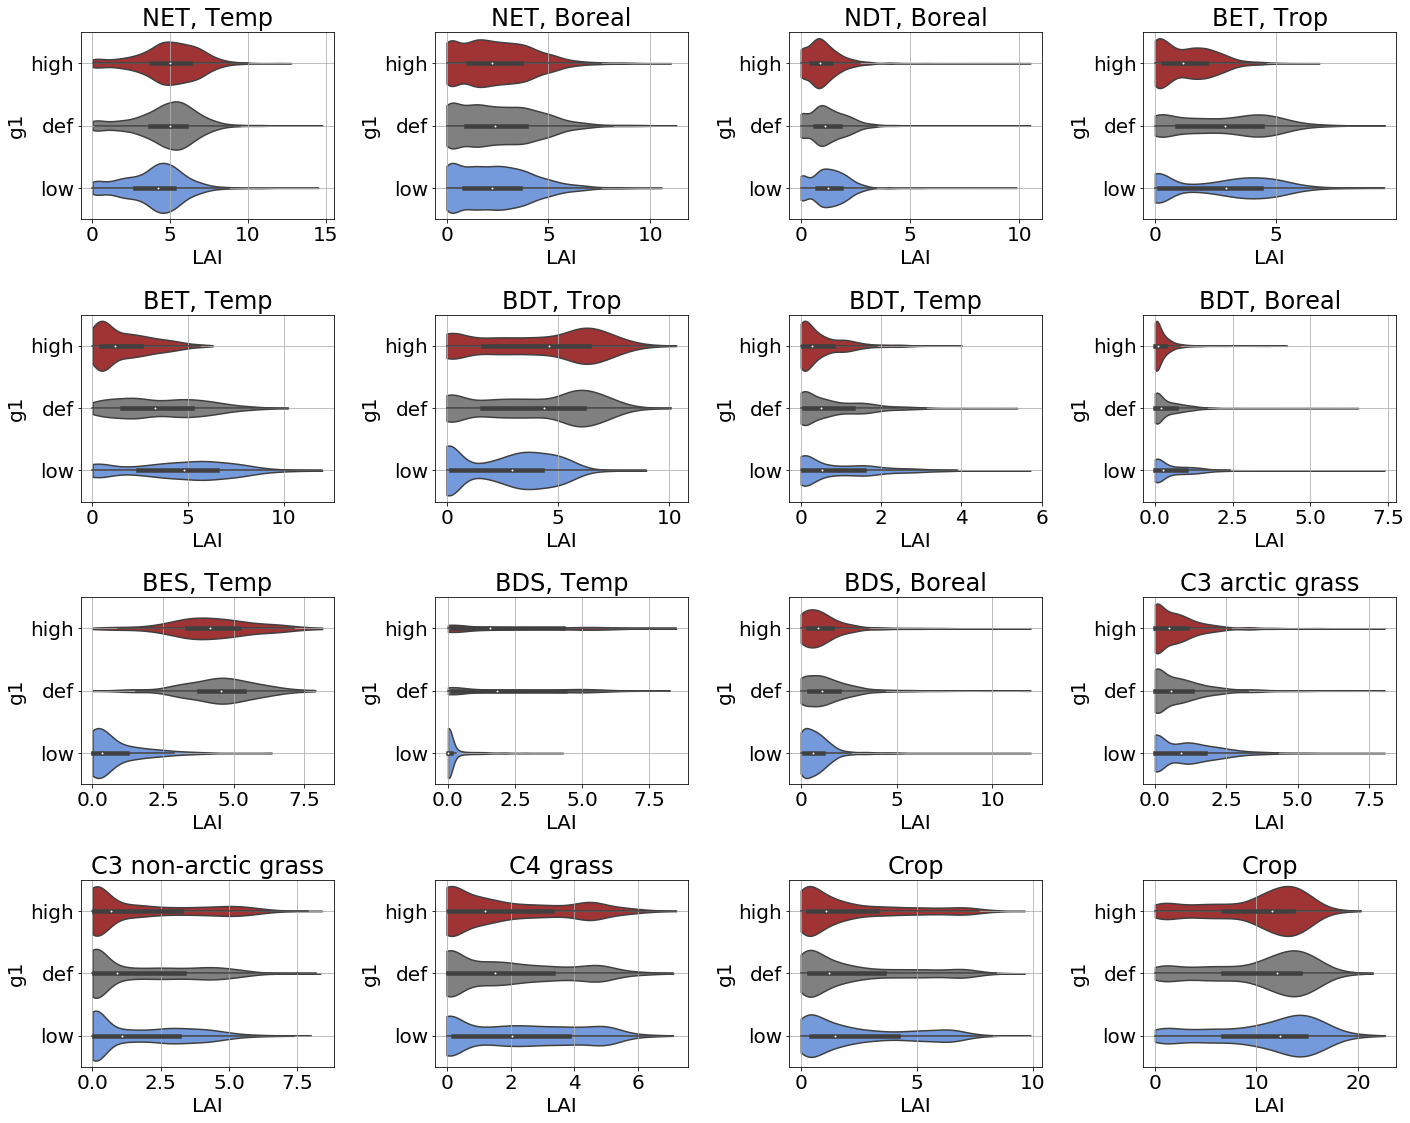

In [6]:
plt.figure(figsize=(20,16))
plt.rcParams.update({'font.size': 20})
for ipft in pftnums[1:]:
    plt.subplot(4,4,int(ipft))
    #print('------------')
    #print(int(ipft))
    df = pd.DataFrame({'high': high_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time'),
                       'def': def_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time'),
                       'low': low_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time')})
    df = df.melt(var_name='g1', value_name='LAI')
    sb.violinplot(y='g1',x='LAI',data=df,palette=['firebrick','grey','cornflowerblue'], cut=0)
    #plt.ylim([0,12])
    plt.title(pftnames[int(ipft)])
    plt.grid()
    #print(len(df))
plt.tight_layout()
plt.savefig('PFT_results.png')

# Time Series of Average LAI for each PFT
(quick first look: not weighted by cell area or by percent PFT in grid cell)

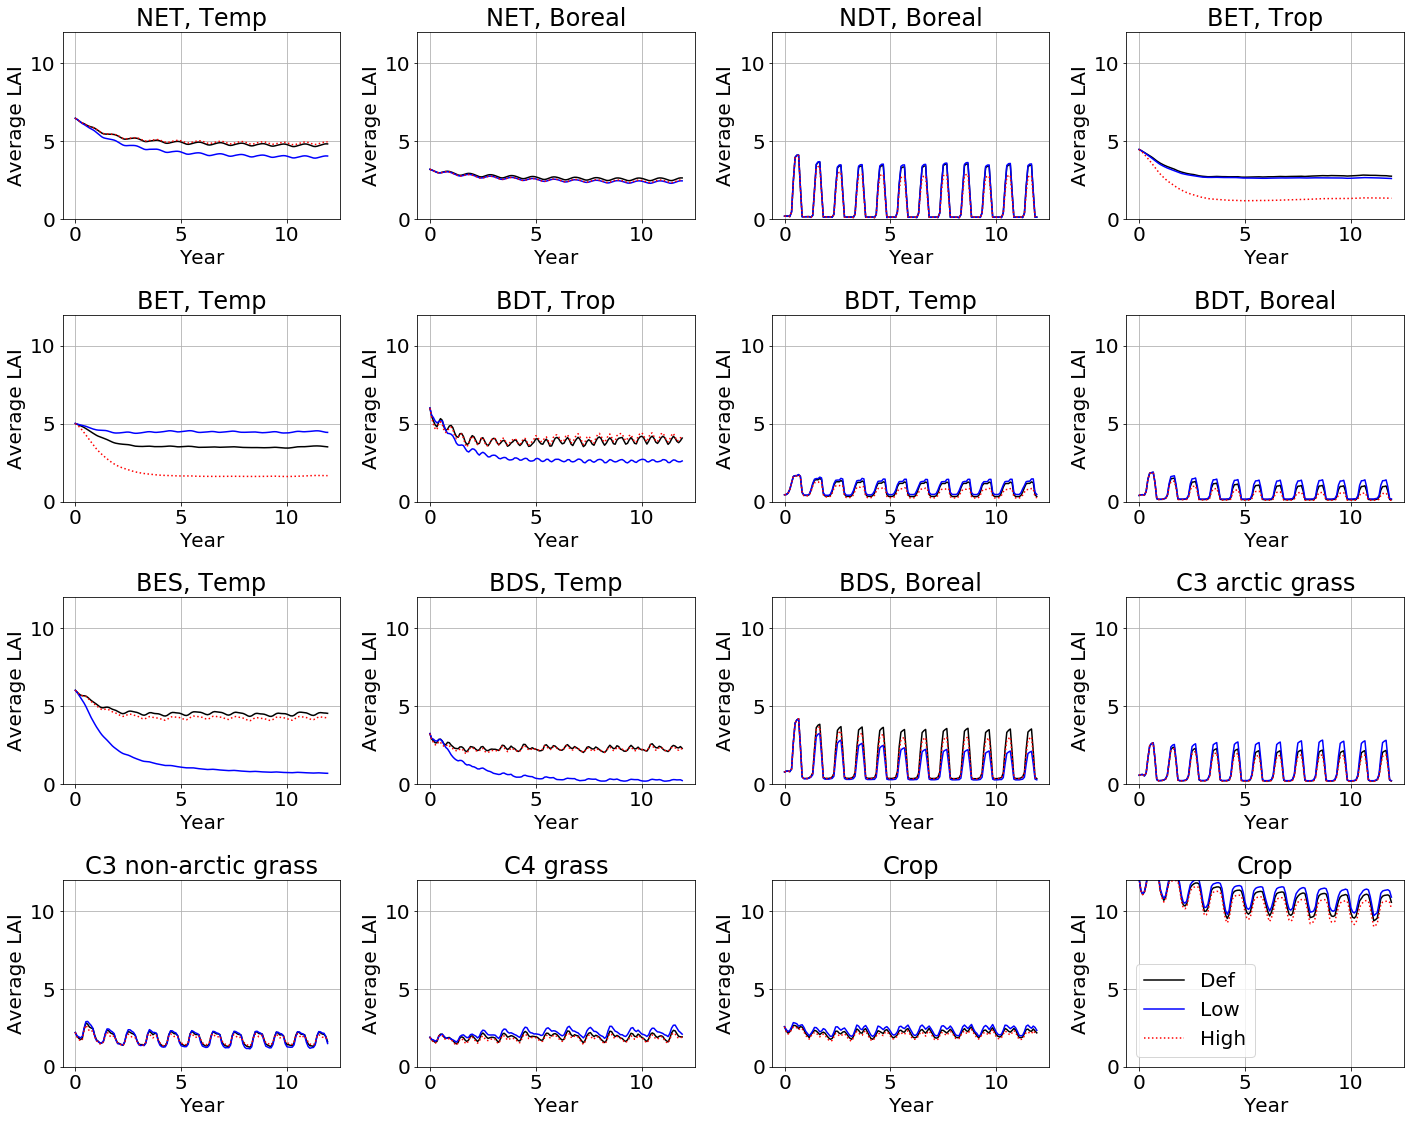

In [7]:
plt.figure(figsize=(20,16))
plt.rcParams.update({'font.size': 20})
for ipft in pftnums[1:]:
    plt.subplot(4,4,int(ipft))
    tlai_pft_low = low_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft).mean(dim='pft')
    tlai_pft_def = def_1xCO2.TLAI.where(def_1xCO2.pfts1d_itype_veg==ipft).mean(dim='pft')
    tlai_pft_high = high_1xCO2.TLAI.where(high_1xCO2.pfts1d_itype_veg==ipft).mean(dim='pft')
    #print('------------')
    #print(int(ipft))
    plt.plot(np.arange(0, 144)/12, tlai_pft_def, '-k', label='Def')
    plt.plot(np.arange(0, 144)/12,tlai_pft_low, '-b', label='Low')
    plt.plot(np.arange(0, 144)/12,tlai_pft_high, ':r',label='High')
    plt.ylim([0,12])
    plt.title(pftnames[int(ipft)])
    plt.ylabel('Average LAI')
    plt.xlabel('Year')
    plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('PFT_results.png')

# Percentage of grid cells where PFTs have LAI < 0.1 in last 2 years

In [12]:
lai_thresh = 0.1
for ipft in pftnums[1:]:
    print('------------')
    print('   '+str(int(ipft))+' ' +pftnames[int(ipft)])
    
    ds = high_1xCO2.TLAI.where(high_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(10*12,13*12)).mean(dim='time')
    pct_dead_high = np.round(len(ds[ds<=lai_thresh])*100/len(ds),2)
    
    ds = def_1xCO2.TLAI.where(def_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(10*12,13*12)).mean(dim='time')
    pct_dead_def = np.round(len(ds[ds<=lai_thresh])*100/len(ds),2)
    
    ds = low_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(10*12,13*12)).mean(dim='time')
    pct_dead_low = np.round(len(ds[ds<=lai_thresh])*100/len(ds),2)
    
    if pct_dead_high>=70:
        print('***high:    '+str(pct_dead_high)+ '% dead')
    else:
        print('   high:    '+str(pct_dead_high)+ '% dead')
    
    if pct_dead_def>=70:
        print('***default: '+str(pct_dead_def)+ '% dead')
    else:
        print('   default: '+str(pct_dead_def)+ '% dead')
    
    if pct_dead_low>=70:
        print('***low:     '+str(pct_dead_low)+ '% dead')
    else:
        print('   low:     '+str(pct_dead_low)+ '% dead')

------------
   1 NET, Temp
   high:    2.96% dead
   default: 3.23% dead
   low:     3.83% dead
------------
   2 NET, Boreal
   high:    10.86% dead
   default: 11.34% dead
   low:     11.76% dead
------------
   3 NDT, Boreal
   high:    14.52% dead
   default: 14.81% dead
   low:     14.91% dead
------------
   4 BET, Trop
   high:    19.51% dead
   default: 13.03% dead
   low:     23.42% dead
------------
   5 BET, Temp
   high:    14.24% dead
   default: 6.82% dead
   low:     8.61% dead
------------
   6 BDT, Trop
   high:    13.35% dead
   default: 13.98% dead
   low:     24.46% dead
------------
   7 BDT, Temp
   high:    29.15% dead
   default: 26.75% dead
   low:     29.49% dead
------------
   8 BDT, Boreal
   high:    49.52% dead
   default: 41.52% dead
   low:     38.21% dead
------------
   9 BES, Temp
   high:    0.86% dead
   default: 0.86% dead
   low:     31.9% dead
------------
   10 BDS, Temp
   high:    25.51% dead
   default: 25.33% dead
***low:     74.9% dead
--

# LAI associated with other low estimates of shrub Medlyn slope

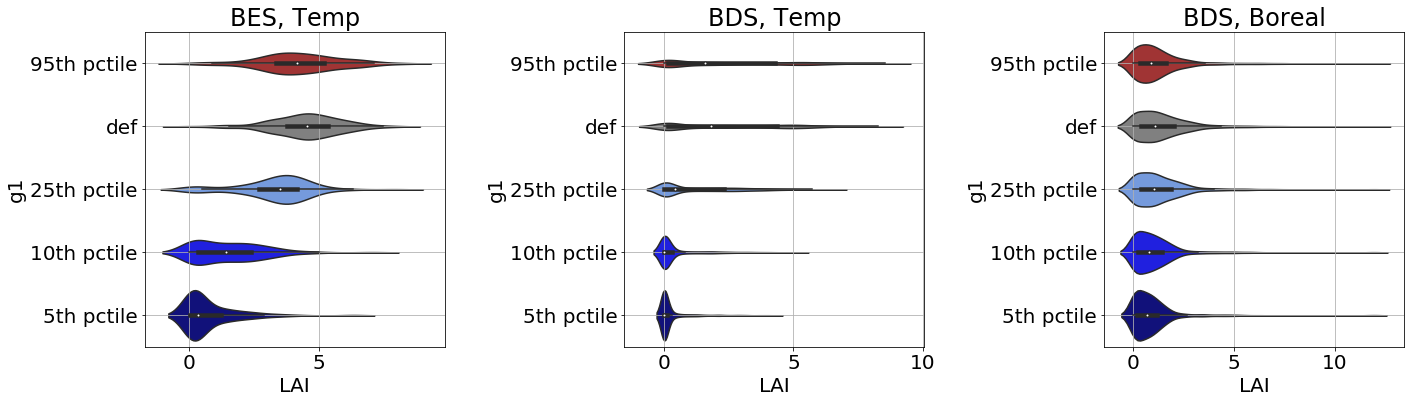

In [9]:
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 20})
for i,ipft in enumerate(np.arange(9,12,1)):
    plt.subplot(1,3,i+1)
    df = pd.DataFrame({'95th pctile': high_1xCO2.TLAI.where(high_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time'),
                       'def': def_1xCO2.TLAI.where(def_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time'),
                       '25th pctile': low3_1xCO2.TLAI.where(low2_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time'),
                       '10th pctile': low2_1xCO2.TLAI.where(low2_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time'),
                       '5th pctile': low_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(8*12,12*12)).mean(dim='time')})
    df = df.melt(var_name='g1', value_name='LAI')
    sb.violinplot(y='g1',x='LAI',data=df,palette=['firebrick','grey','cornflowerblue','blue','darkblue'])#, cut=0)
    #plt.ylim([0,12])
    plt.title(pftnames[int(ipft)])
    plt.grid()
plt.tight_layout()
plt.savefig('PFT_results.png')

In [13]:
lai_thresh = 0.1
for i,ipft in enumerate(np.arange(9,12,1)):
    print('------------')
    print('   '+str(int(ipft))+' ' +pftnames[int(ipft)])
    
    ds = low_1xCO2.TLAI.where(low_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(10*12,13*12)).mean(dim='time')
    pct_dead_low = np.round(len(ds[ds<=lai_thresh])*100/len(ds),2)
    
    ds = low2_1xCO2.TLAI.where(low2_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(10*12,13*12)).mean(dim='time')
    pct_dead_low2 = np.round(len(ds[ds<=lai_thresh])*100/len(ds),2)
    
    ds = low3_1xCO2.TLAI.where(low3_1xCO2.pfts1d_itype_veg==ipft, drop=True).isel(time=slice(10*12,13*12)).mean(dim='time')
    pct_dead_low3 = np.round(len(ds[ds<=lai_thresh])*100/len(ds),2)
    
    if pct_dead_low>=70:
        print('*** 5th percentile:     '+str(pct_dead_low)+ '% dead')
    else:
        print('    5th percentile:     '+str(pct_dead_low)+ '% dead')
        
    if pct_dead_low2>=70:
        print('***10th percentile:     '+str(pct_dead_low2)+ '% dead')
    else:
        print('   10th percentile:     '+str(pct_dead_low2)+ '% dead')
    
    if pct_dead_low3>=70:
        print('***25th percentile:     '+str(pct_dead_low3)+ '% dead')
    else:
        print('   25th percentile:     '+str(pct_dead_low3)+ '% dead')

------------
   9 BES, Temp
    5th percentile:     31.9% dead
   10th percentile:     16.38% dead
   25th percentile:     5.17% dead
------------
   10 BDS, Temp
*** 5th percentile:     74.9% dead
   10th percentile:     64.53% dead
   25th percentile:     38.44% dead
------------
   11 BDS, Boreal
    5th percentile:     21.04% dead
   10th percentile:     19.58% dead
   25th percentile:     18.52% dead
